# Теория

В отличие от прямых методов, которые требуют только унимодальности функции, метод дихотомии с производной (или метод средней точки) требует так же дифференцируемости. Для выпуклой дифференцируемой функции равенство $f'(x) = 0$ является не только необходимым, но и достаточным условием глобального минимума. Поэтому, если известно что $x^{*}$ является внутренней точкой отрезка $[a, b]$, то приближенное равенство $ f'(x) \approx 0$ или $|f'(x)| \leq \epsilon $ может служить условием остановки вычислений в рассматриваемом методе.

#### Суть метода 
Вычисляем $f'(x)$ в серединной точке отрезка $\overline{x} = \frac{a+b}{2}$. Если $f'(x) > 0$, то точка $\overline{x}$ лежит на участке монотонного возрастания $f(x)$, поэтому $x^{*} < \overline{x} $ и точку минимума следует искать на отрезке $[a, \overline{x}] $. При $f'(x) < 0$ переходим к отрезку $[\overline{x}, b] $. И соответственно когда $f'(x) = 0$ или с заданной точностью равно нулю, то точка минимума найдена.

# Реализация вспомогательных классов и функций 

In [34]:
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from typing import List 
from dataclasses import dataclass

sns.set_style("darkgrid")

In [35]:
class Function:
    def __init__(self, f):
        x = sp.Symbol('x')
        self.f = sp.lambdify(x, f) # наша функции которую мы передали 
        self.g = sp.lambdify(x, f.diff(x)) # производная функции
        self.h = sp.lambdify(x, f.diff(x, 2)) # 2 производная
    
    def calculate(self, x):
        return self.f(x)
    
    def gradient(self, x):
        return self.g(x)
    
    def hesse(self, x):
        return self.h(x)


@dataclass
class Result:
    xmin: float = None # значение аргумента на котором достикается минимум функции
    fmin: float = None # минимальное значение функции
    solution_time: float = 0 # время расчета
    iteration_amount: float = None # количество итераций
    progress: List = None # массив где мы сохраняем значения нашего алгоритма на каждой итерации: итерация, xmin, fmin
    status: str = '' # удачно или нет выполнился наш метод
    func_str: str='' # названия функции на которой мы применяем наш алгорит

    def print(self):
        print('\nFunction: {}'.format(self.func_str)) 
        if self.status == 'Failure': 
            print('\nFailure: min is -inf.')
        else:
            print('Solution: x = {:.3f}, f(x) = {:.3f}'.format(self.xmin, self.fmin))
            print('Time: {:.8f}'.format(self.solution_time))
            print(f'Interations: {self.iteration_amount}')

# Реализация метода

In [36]:
def dichotomy(func: Function, a, b, accuracy: float, max_iterations=1e5, func_str=""):
    n = 0 # кол-во итераций
    start_time = time.time() #  время старта
    res = Result() # результат работы
    res.progress = [] 
    x = (a + b) / 2
    fx = func.gradient(x)

    while np.abs(fx) > accuracy and n < max_iterations and np.abs(b-a) > accuracy:
            n += 1
            x = (a + b) / 2.0
            fx= func.gradient(x)
            fa = func.gradient(a)
            res.progress.append([n, x, fx])
            if (fx < 0 and fa <0):
                a = x
            else:
                b = x
    
        
    res.xmin = x
    res.fmin = func.calculate(x)
    if n >= max_iterations:
        res.status = 'Failure'
    res.iteration_amount = n
    res.solution_time = time.time() - start_time
    res.func_str = func_str
    return res

# Код для построения графиков

In [37]:
def plot_accuracy(a, b, accuracy, acc_lim, acc_step, func, func_str):
    t = np.array([])
    acc = np.array([])
    n = np.array([])
    
    while accuracy > acc_lim:
        accuracy -= acc_step
        sol = dichotomy(func, a, b, accuracy)
        t = np.append(t, sol.solution_time)
        acc = np.append(acc, accuracy)
        n = np.append(n, sol.iteration_amount)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    ax1.plot(acc, n)
    ax2.plot(acc, n)
    ax3.plot(acc, t)

    titles = ["Число итераций по переменной от точности решения ${}$".format(func_str),
             "Число итераций по функции от точности решения ${}$".format(func_str),
             "Время решения ${}$ от требуемой точности".format(func_str)]
    y_labels = ["Число итераций", "Число итераций", "Время"]
    x_labels = ["Точность ", "Точность", "Точность"]

    for i, ax in enumerate([ax1, ax2, ax3]):
        ax.set_title(titles[i])
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel(y_labels[i])

    plt.show()

In [38]:
x = sp.Symbol('x')

# Вычисление минимумов функций на отрезках

In [39]:
sol1 = dichotomy(Function(x**2), -1, 10, 0.00001, func_str="x^2")

sol2 = dichotomy(Function((x+5)**4), -6, 2, 0.00001, func_str="(x+5)^4")

sol3 = dichotomy(Function(x * sp.exp(x)), -2, 0, 0.00001, func_str="x * exp(x)")

sol4 = dichotomy(Function(x * sp.exp(-x)), -2, 6, 0.0001, func_str="x * exp(-x)")
sol5 = dichotomy(Function(x**4 / sp.ln(x)), 1.1, 1.5, 0.00001, func_str="x^4 / ln(x)")
sol1.print()
sol2.print()
sol3.print()
sol4.print()
sol5.print()



Function: x^2
Solution: x = -0.000, f(x) = 0.000
Time: 0.00125599
Interations: 20

Function: (x+5)^4
Solution: x = -5.000, f(x) = 0.000
Time: 0.00003982
Interations: 3

Function: x * exp(x)
Solution: x = -1.000, f(x) = -0.368
Time: 0.00003099
Interations: 0

Function: x * exp(-x)
Solution: x = -2.000, f(x) = -14.777
Time: 0.00010180
Interations: 17

Function: x^4 / ln(x)
Solution: x = 1.284, f(x) = 10.873
Time: 0.00046206
Interations: 16


## $f(x) = x^2$ on $[-1, 10]$

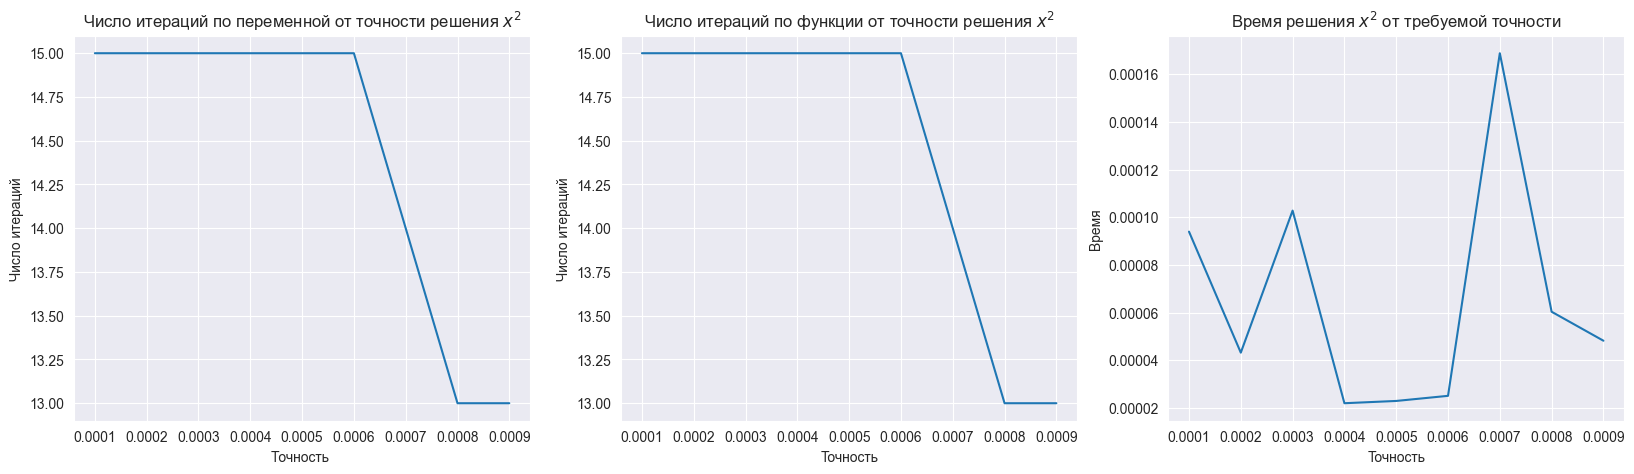

In [40]:
plot_accuracy(-1, 10, 1e-3, 1e-4, 1e-4, Function(x**2), "x^2")

## $f(x) = (x+5)^4$ on $[-6, 2]$

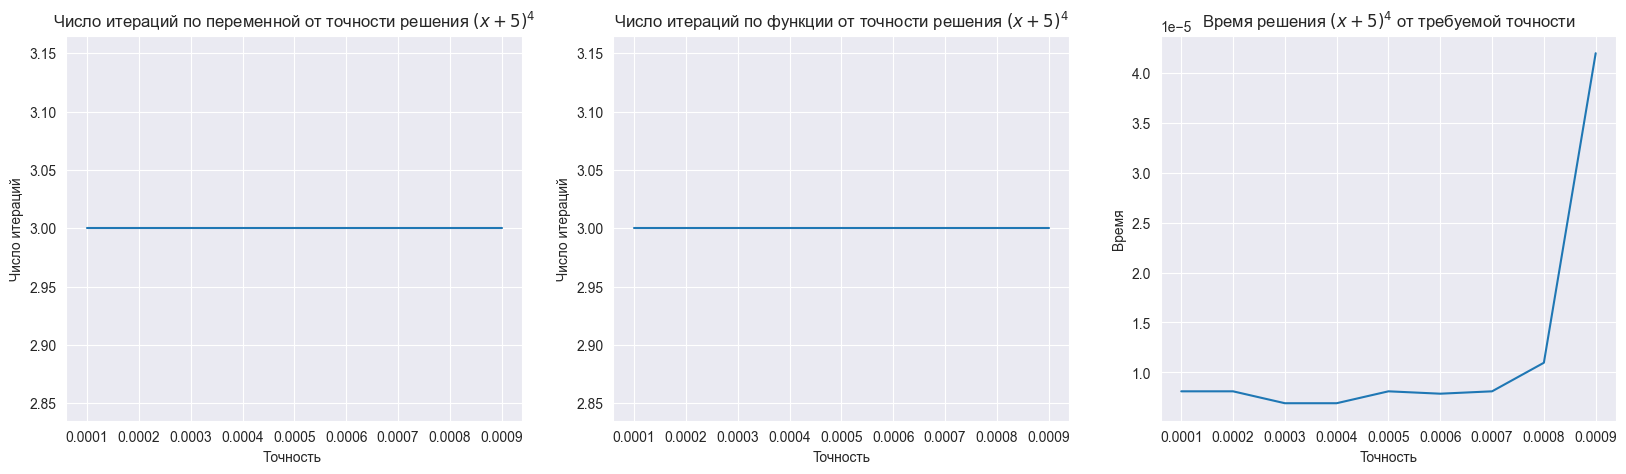

In [41]:
plot_accuracy(-6, 2, 1e-3, 1e-4, 1e-4, Function((x+5)**4), "(x+5)^4")

## $f(x) = x \cdot exp(x)$ on $[-2, 0]$

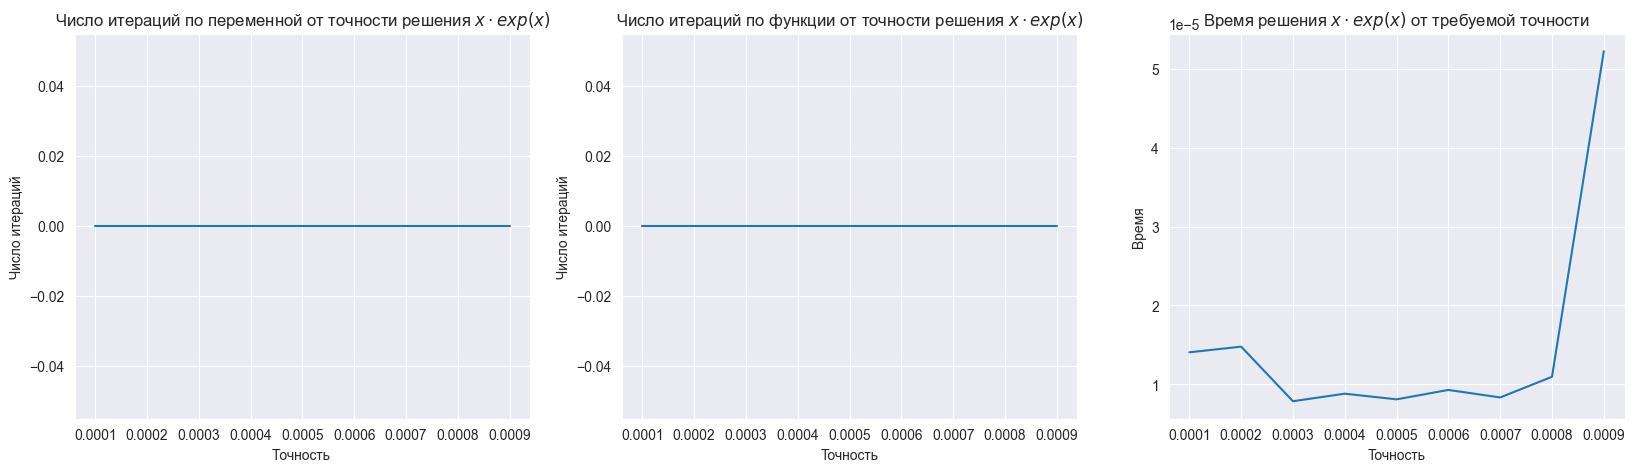

In [42]:
plot_accuracy(-2, 0, 1e-3, 1e-4, 1e-4, Function(x * sp.exp(x)), "x \cdot exp(x)")

## $f(x) = x \cdot exp(-x)$ on $[-2, 6]$

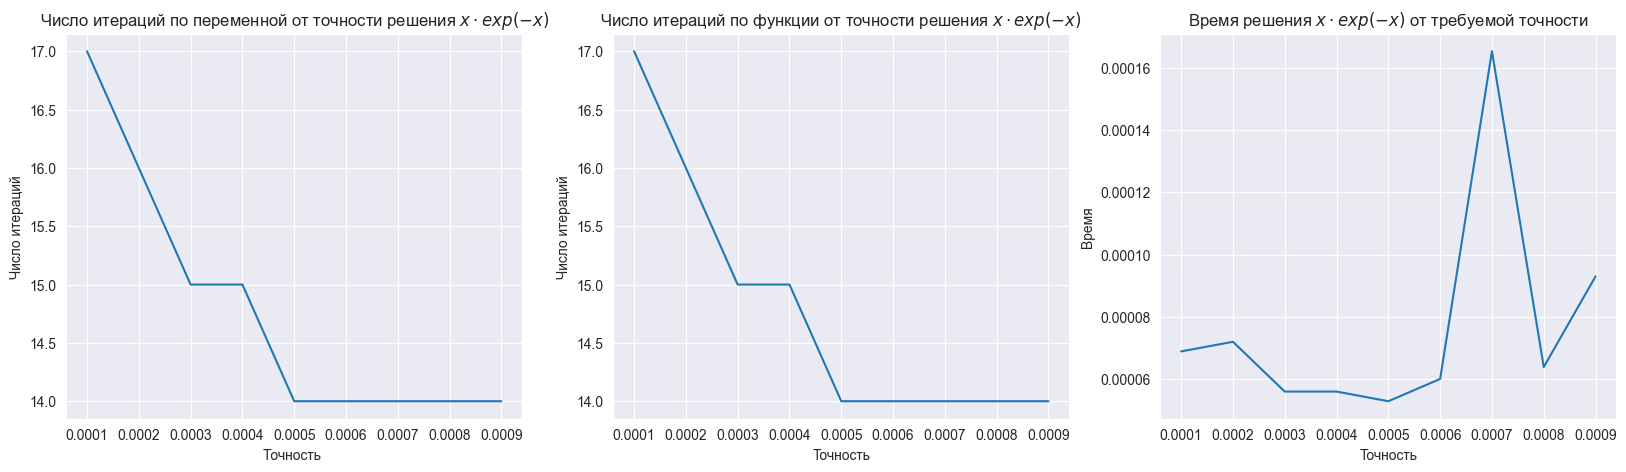

In [43]:
plot_accuracy(-2, 6, 1e-3, 1e-4, 1e-4, Function(x * sp.exp(-x)), "x \cdot exp(-x)")

## $f(x) = \frac{x^4}{ln(x)} $ on $[1.1, 1.5]$

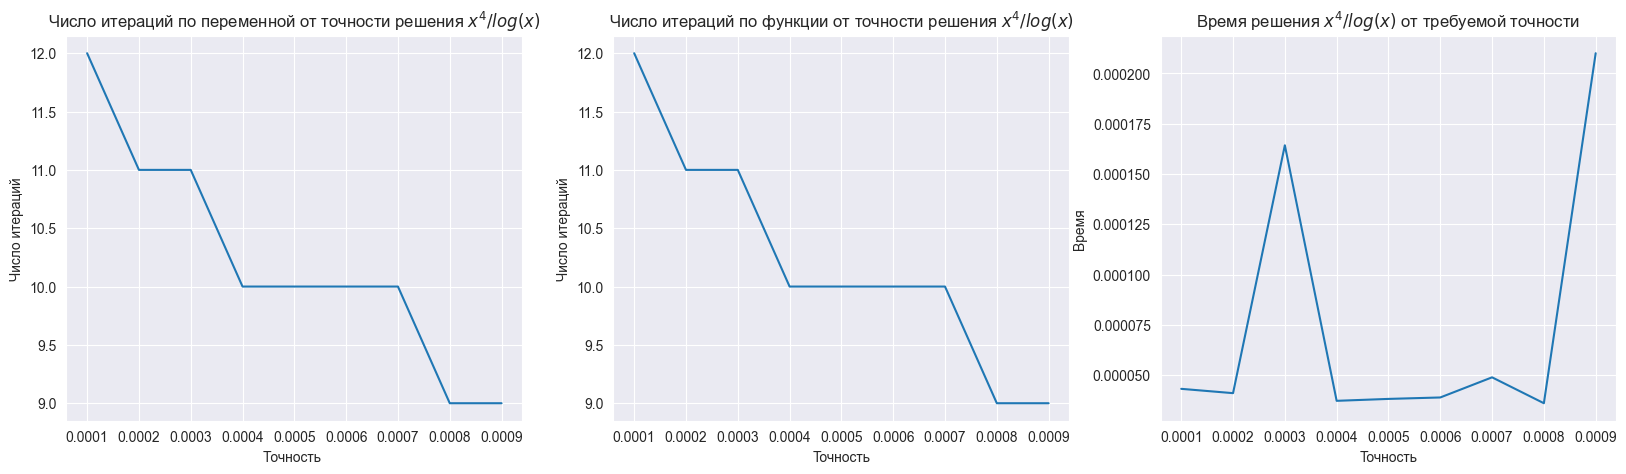

In [44]:
plot_accuracy(1.1, 1.5, 1e-3, 1e-4, 1e-4, Function(x**4 / sp.log(x)), "x^4 / log(x)")